# Transfer Learning

In transfer learning, the knowledge of an already trained machine learning model is applied to a different but related problem. For example, if you trained a simple classifier to predict whether an image contains a watch, you could use the knowledge that the model gained during its training to recognize other objects like clock.

## Pre-trained model as Feature Extractor
Remove the last dense layer which is performing classification and use this pre-trained model as Feature Extractor.Fixed feature extractor for the new dataset.
For example, if you want to build a self learning car. You can spend years to build a decent image recognition algorithm from scratch or you can take inception model (a pre-trained model) from Google which was built on ImageNet data to identify images in those pictures.

![tf](../picture/tf.jpeg)

## VGG16 model 
VGG is a deep convolutional neural network that was proposed by Karen Simonyan and Andrew Zisserman. VGG is an acronym for their group name, Visual Geometry Group, from the Oxford University. This model secured 2nd place in the ILSVRC-2014 competition where 92.7% classification performance was achieved. The VGG model investigates the depth of layers with a very small convolutional filter size (3 × 3) to deal with large-scale images. 

The structure of VGG16 is described by the following figure:
![vgg16](../picture/vgg16.png)

Figure is shown the architecture of VGG16. Source: Researchgate.net

VGG16 is composed of 13 convolutional layers, 5 max-pooling layers, and 3 fully connected layers. Therefore, the number of layers having tunable parameters is 16 (13 convolutional layers and 3 fully connected layers). That is the reason why the model name is VGG16. The number of filters in the first block is 64, then this number is doubled in the later blocks until it reaches 512. This model is finished by two fully connected hidden layers and one output layer. The two fully connected layers have the same neuron numbers which are 4096. The output layer consists of 1000 neurons corresponding to the number of categories of the Imagenet dataset. In the next section, we are going to implement this architecture on Keras.[Source](https://medium.com/mlearning-ai/an-overview-of-vgg16-and-nin-models-96e4bf398484)

VGG16 used large feature sizes in many layers and thus inference was quite costly at run-time. But we decide to select to training in my project because that is starter model in transfer learning image classification and easy to pre-processing for training. 

In [1]:
# Import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image

# Open file
import os
import PIL

# Model CNN (Deep learning network)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,\
GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set default random state 
from random import seed

In [6]:
# Create function plot loss function and accuracy score graph
def plot_graph(model_values):
    ''' 
    Input : Model_values of keras.callbacks.History
    Return : Graph of Loss function and accuracy score between training dataset and vaildation dataset
    '''
    # Subplots
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(model_values.history['loss'], label='Training Loss');
    plt.plot(model_values.history['val_loss'], label='Testing Loss');
    plt.legend(fontsize=12, loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss');
    
    # Plot MSE
    plt.subplot(1, 2, 2)
    
    plt.plot(model_values.history['accuracy'], label='Training Accuracy')
    plt.plot(model_values.history['val_accuracy'], label='Validation Accuracy')
    
    plt.legend(fontsize=12, loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy');

### 00 First, check GPU.
---

In [1]:
# https://www.tensorflow.org/guide/keras/sequential_model
# Due to we use Keras Sequential API, 
# We want to check GPU first before training our model for 
# impore efficiency and reduce time. 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12212482257788027880
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2914307278
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4985773651961320483
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


### 01 Open dataset 
---

In [2]:
# Open path file of dataset 
seed(42)
dataset_path_new = "dataset_train_valid_test"

train_dir = os.path.join(dataset_path_new, "train")
valid_dir = os.path.join(dataset_path_new, "valid")
test_dir = os.path.join(dataset_path_new, "test")

### 02 Preprocessing image dataset 
---

In [3]:
# Set parameter of image 
# The default input size for this VGG16 model is 224x224
# https://keras.io/api/applications/vgg/
batch_size = 50 # Set the batch size for epoch cycle
img_height = 224 # Set the height of the picture
img_width = 224 # Set the width of the picture

# Rescale pixel to reduce image size before using in model
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)
data_gen_test = ImageDataGenerator(rescale=1/255.)

In [4]:
# Create training dataset 
train_dataset = data_gen_train.flow_from_directory(train_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)
 

# Create validation dataset 
valid_dataset = data_gen_valid.flow_from_directory(valid_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)

# Create testing dataset 
test_dataset = data_gen_test.flow_from_directory(test_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)

Found 7796 images belonging to 4 classes.
Found 816 images belonging to 4 classes.
Found 805 images belonging to 4 classes.


---

### 03 VGG16 model training 
---

#### Transfer learning

In [5]:
# import vgg16 model form keras API
# set input size of image of trianing is 224x224
# due to we want to use transfer learning process 
# we must add `include_top=False` because we wan to add our input data 
# we decide default weigh for model 
vgg16_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                          include_top=False, # Transfer learning
                                          weights="imagenet",
                                          )

In [6]:
# model summary
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
# fix weights and bias in hidden layers
# train specifically custom head and output layer
vgg16_model.trainable=False

#### Add custom head and output layers 

In [8]:
# Create output layer 
# We have 4 classes in our output we decide using activation="softmax" 
# for multi classification.
# Before output layer we decide use GlobalAveragePooling2D as 
# one type of flatten layer.
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(vgg16_model.output) # flatten
prediction_layer = tf.keras.layers.Dense(units=4, activation="softmax")(average_pooling_layer)

In [9]:
# Add Input layer and output layer 
model = tf.keras.models.Model(inputs=vgg16_model.input, 
                                    outputs=prediction_layer)

In [10]:
# compile the model         
model.compile(loss="categorical_crossentropy", 
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [11]:
# check model summary
# total params: 14,716,740 (hidden layers)
# trainable params: 2,052 (input and output layers)
model.summary()  

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# Save checkpoints during training
checkpoint_path = "../model/vgg16/training_vgg16_cp/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [15]:
# Training model
# make sure you truely save checkpoint_path
history = model.fit(train_dataset,
          epochs=25,
          validation_data=valid_dataset,
          callbacks=[cp_callback])

Epoch 1/25
156/156 [==============================] - ETA: 0s - loss: 1.2118 - accuracy: 0.5428
Epoch 1: saving model to ../model/vgg16/training_vgg16_cp\cp.ckpt
156/156 [==============================] - 367s 2s/step - loss: 1.2118 - accuracy: 0.5428 - val_loss: 0.9927 - val_accuracy: 0.7047
Epoch 2/25
156/156 [==============================] - ETA: 0s - loss: 0.9373 - accuracy: 0.6854
Epoch 2: saving model to ../model/vgg16/training_vgg16_cp\cp.ckpt
156/156 [==============================] - 311s 2s/step - loss: 0.9373 - accuracy: 0.6854 - val_loss: 0.8401 - val_accuracy: 0.7292
Epoch 3/25
156/156 [==============================] - ETA: 0s - loss: 0.8297 - accuracy: 0.7113
Epoch 3: saving model to ../model/vgg16/training_vgg16_cp\cp.ckpt
156/156 [==============================] - 306s 2s/step - loss: 0.8297 - accuracy: 0.7113 - val_loss: 0.7949 - val_accuracy: 0.7279
Epoch 4/25
156/156 [==============================] - ETA: 0s - loss: 0.7675 - accuracy: 0.7301
Epoch 4: saving model 

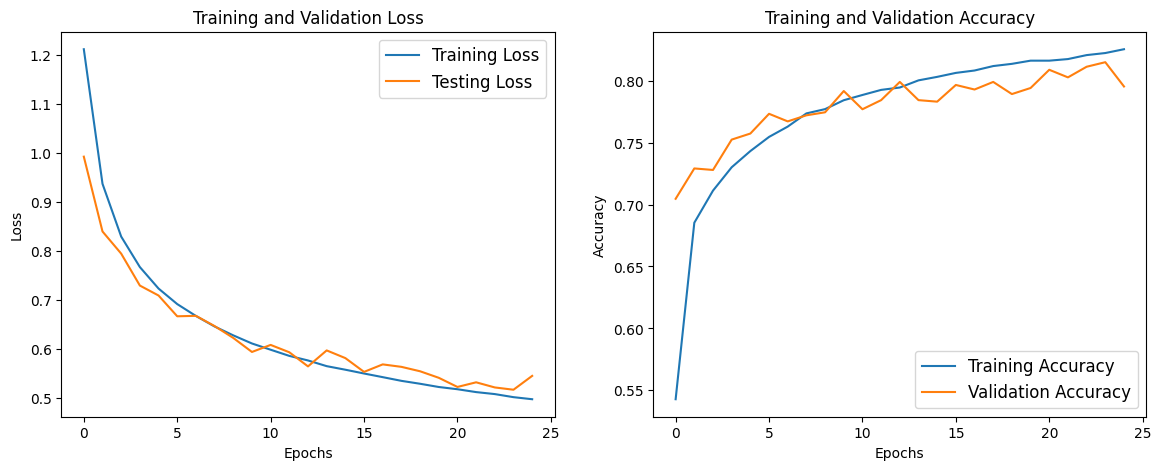

In [17]:
# plot graph 
plot_graph(history)

# Not overfitting between training and validation 
# Final accuracy after training 25 epochs is score in training 0.83% 
# and vaildaion 0.80%
# Loss function after training 25 epochs is score in training 0.50% 
# and vaildaion 0.55%
# Lower perfomance than baseline model 

# Good performance! but not enough !  
# We have choice to improve my model 

In [31]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.211807,0.542843,0.992671,0.704657
1,0.937318,0.685351,0.840077,0.729167
2,0.829674,0.711262,0.794889,0.727941
3,0.767488,0.730118,0.729752,0.752451
4,0.723653,0.743202,0.709460,0.757353


In [32]:
# save history to csv: 
hist_csv_file = 'history_vgg16.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [30]:
# save model
model.save("../model/vgg16/vgg_16.h5")

---

#### Fine tuning
---

![vgg_ft](../picture/vgg_ft.png)
Fine-tuning is a way of applying or utilizing transfer learning. Specifically, fine-tuning is a process that takes a model that has already been trained for one given task and then tunes or tweaks the model to make it perform a second similar task.

we don't want the weights for these layers to update whenever we train the model on our new data for our new task. We want to keep all of these weights the same as they were after being trained on the original task. We only want the weights in our new or modified layers to be updating. After we do this, all that's left is just to train the model on our new data. Again, during this training process, the weights from all the layers we kept from our original model will stay the same, and only the weights in our new layers will be updating.[Source](https://deeplizard.com/learn/video/5T-iXNNiwIs)

We decide to fix the weight in our model 0 - 14 layers because that are related with structure of image but after layer related with feature of image. 

In [34]:
img_height = 224 # Set the height of the picture
img_width = 224 # Set the width of the picture

# load model
vgg16_model = tf.keras.applications.VGG16(input_shape=(img_height, img_width,3),
                                          include_top=False, # Transfer learning
                                          weights="imagenet",
                                          )  

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(vgg16_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16_model.layers[:fine_tune_at]:
    layer.trainable = False

# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg16_model.layers):
    print(i, layer.name, layer.trainable)

# Add input layers and output layers
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(vgg16_model.output) # flatten
prediction_layer = tf.keras.layers.Dense(units=4, activation="softmax")(average_pooling_layer)
fineture_model = tf.keras.models.Model(inputs=vgg16_model.input, 
                                     outputs=prediction_layer)

# Compile the model         
fineture_model.compile(loss="categorical_crossentropy", 
                       optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                       metrics=['accuracy'])

Number of layers in the base model:  19
0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [35]:
# Save checkpoints during training
# follow value of vaildation scorce 
checkpoint = tf.keras.callbacks.ModelCheckpoint('../model/vgg16/vgg_16.h5', 
                             monitor= 'val_accuracy', 
                             mode= 'max', 
                             save_best_only = True, 
                             verbose= 1)

In [36]:
# Training model
# make sure you truely save checkpoint_path
history_ft = fineture_model.fit(train_dataset,  
                             epochs=10, 
                             validation_data=valid_dataset, 
                             callbacks=[checkpoint]) # fine tune continue form transfer learning

Epoch 1/10
156/156 [==============================] - ETA: 0s - loss: 0.8867 - accuracy: 0.6276
Epoch 1: val_accuracy improved from -inf to 0.79657, saving model to ../model/vgg16\vgg_16.h5
156/156 [==============================] - 310s 2s/step - loss: 0.8867 - accuracy: 0.6276 - val_loss: 0.5216 - val_accuracy: 0.7966
Epoch 2/10
156/156 [==============================] - ETA: 0s - loss: 0.4251 - accuracy: 0.8476
Epoch 2: val_accuracy improved from 0.79657 to 0.89583, saving model to ../model/vgg16\vgg_16.h5
156/156 [==============================] - 313s 2s/step - loss: 0.4251 - accuracy: 0.8476 - val_loss: 0.2998 - val_accuracy: 0.8958
Epoch 3/10
156/156 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.9120
Epoch 3: val_accuracy did not improve from 0.89583
156/156 [==============================] - 311s 2s/step - loss: 0.2681 - accuracy: 0.9120 - val_loss: 0.3186 - val_accuracy: 0.8860
Epoch 4/10
156/156 [==============================] - ETA: 0s - loss: 0.20

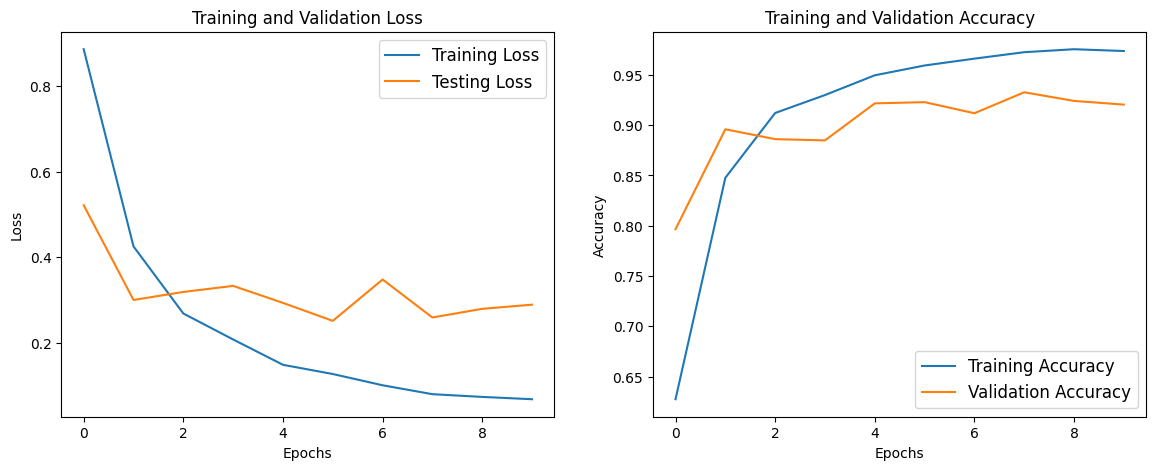

In [37]:
# plot graph 
plot_graph(history_ft)

# Slightly overfitting between training and validation 
# Final accuracy after fine tuning 10 epochs is up score in training 0.97% 
# and vaildaion 0.92% (better than transfer learning)
# Loss function after training 25 epochs is down score in training 0.07% 
# and vaildaion 0.30% (better than transfer learning)
# Higher perfomance than baseline model  

In [38]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_ft.history) 
hist_df.head()

# save to csv: 
hist_csv_file = '../model/vgg16/history_vgg16_ft.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [39]:
# save model after fine tuning 
fineture_model.save("../model/vgg16/vgg_16_ft.h5")

---